In [1]:
import os

In [2]:
original_folder_path = '/kaggle/input/pneumonia-dataset'

In [3]:
# Iterate over subfolders in the folder
for subfolder in os.listdir(original_folder_path):
    subfolder_path = os.path.join(original_folder_path, subfolder)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Count the number of files in the subfolder
        file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])

        # Display subfolder name and file count
        print(f"Subfolder: {subfolder}, Files: {file_count}")

Subfolder: Pneumonia, Files: 103
Subfolder: Normal, Files: 179


In [4]:
! pip install python_splitter
import python_splitter
python_splitter.split_from_folder(original_folder_path, train=0.7, val=0.2, test=0.1)

✅Checking SOURCE directory...
0.7 0.2 0.1
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 10
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/working/Train_Test_Folder/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory='/kaggle/working/Train_Test_Folder/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory='/kaggle/working/Train_Test_Folder/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 197 files belonging to 2 classes.
Found 28 files belonging to 2 classes.
Found 57 files belonging to 2 classes.


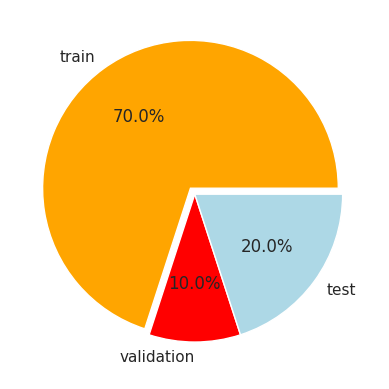

In [7]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [8]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['Normal', 'Pneumonia']
['Normal', 'Pneumonia']
['Normal', 'Pneumonia']


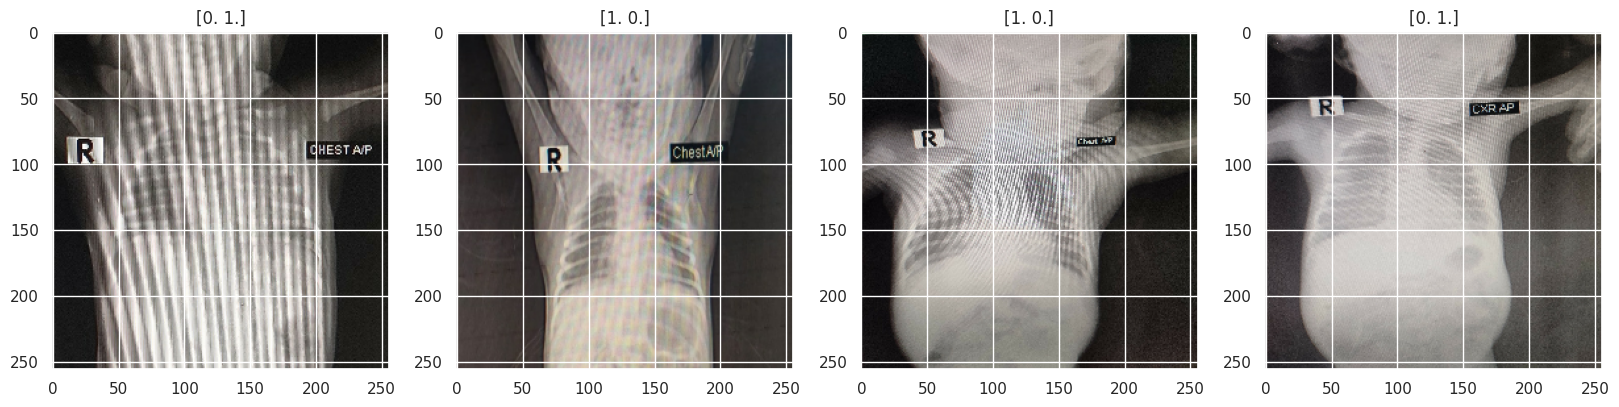

In [9]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
# Extracting Features and Labels
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [11]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val':", y_val.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

Shape of 'x_train': (197, 256, 256, 3)
Shape of 'y_train': (197, 2)
Shape of 'x_val': (28, 256, 256, 3)
Shape of 'y_val': (28, 2)
Shape of 'x_test': (57, 256, 256, 3)
Shape of 'y_test': (57, 2)


In [12]:
# Pixel Value Scaling for Datasets: Normalizing and Standardizing the Data
x_train=x_train/256
x_val=x_val/256
x_test=x_test/256

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18909378 (72.13 MB)
Trainable params: 1127

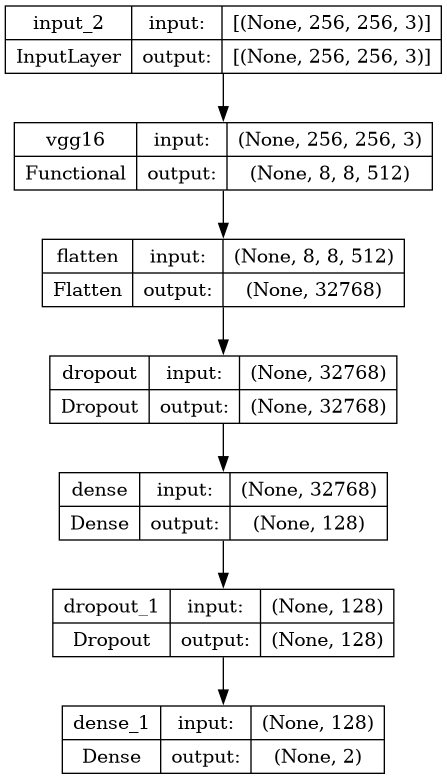

In [13]:
# We use transfer learning with VGG16 as the base model
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.2))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  
# Visualized Layers of CNN
keras.utils.plot_model(model, show_shapes=True)

In [14]:
hist = model.fit(x_train, y_train, epochs= epochs, validation_data= (x_val, y_val))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Epoch 1/10
7/7 [==============================] - 17s 1s/step - loss: 9.3439 - accuracy: 0.5076 - val_loss: 3.9115 - val_accuracy: 0.6429
Epoch 2/10
7/7 [==============================] - 1s 191ms/step - loss: 2.9566 - accuracy: 0.5838 - val_loss: 2.1446 - val_accuracy: 0.6429
Epoch 3/10
7/7 [==============================] - 1s 190ms/step - loss: 2.1784 - accuracy: 0.6142 - val_loss: 1.8681 - val_accuracy: 0.6429
Epoch 4/10
7/7 [==============================] - 1s 192ms/step - loss: 1.7041 - accuracy: 0.6294 - val_loss: 1.3988 - val_accuracy: 0.6429
Epoch 5/10
7/7 [==============================] - 1s 190ms/step - loss: 1.2712 - accuracy: 0.6345 - val_loss: 1.0884 - val_accuracy: 0.6429
Epoch 6/10
7/7 [==============================] - 1s 190ms/step - loss: 1.0689 - accuracy: 0.6244 - val_loss: 0.9842 - val_accuracy: 0.6429
Epoch 7/10
7/7 [==============================] - 1s 187ms/step - loss: 0.9636 - accuracy: 0.6345 - val_loss: 0.8987 - val_accuracy: 0.6429
Epoch 8/10
7/7 [======

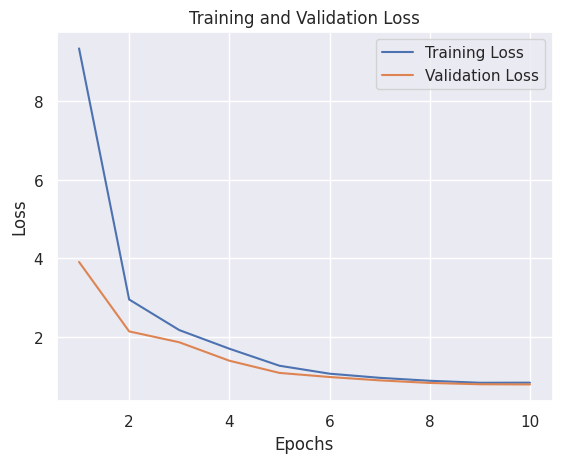

In [15]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

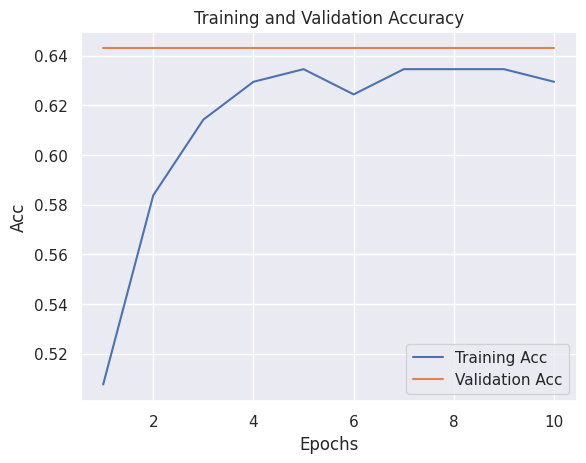

In [16]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'model_name' is not defined

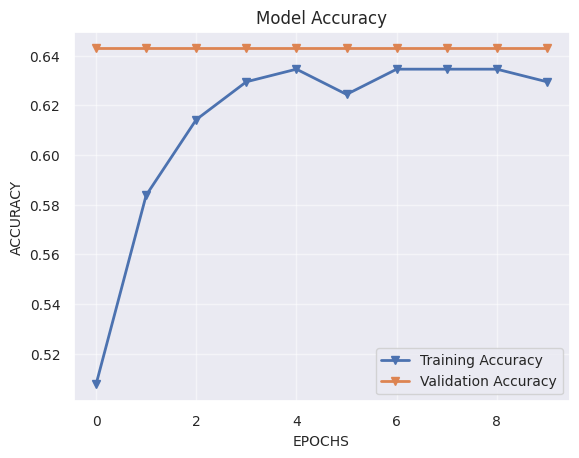

In [18]:
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# --------------Model Accuracy-----------#

# Plot training accuracy with a solid blue line and validation accuracy with a solid red line
plt.plot(hist.history['accuracy'], label='Training Accuracy',  linewidth=2, marker='v')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy',  linewidth=2, marker='v')

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.5)

# Set the title, labels, and legend
plt.title('Model Accuracy', fontsize=12)
plt.xlabel('EPOCHS', fontsize=10)
plt.ylabel('ACCURACY', fontsize=10)
plt.legend(fontsize=10 )

# Customize the x and y axis tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend with a shadow and a legend title
accuracy_title = model_name + " Model Accuracy"
plt.legend(fontsize=10, loc='lower right')
plt.gca().set_title(accuracy_title, fontsize=12)

# Customize the X-axis tick locator and formatter
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer X-axis tick locator
ax.set_xticks(np.arange(0, len(history.history['accuracy'])))  # Set ticks at all integer positions

# Adjust figure size (optional)
fig = plt.gcf()
fig.set_size_inches(6, 4)

# Save the figure in high resolution (e.g., 300 DPI) as a PNG file
plot_title = model_name + " accuracy_plot.png"
fig.savefig(plot_title, dpi=1000, bbox_inches='tight')

# Show or save the plot
plt.tight_layout()
plt.show()

# ------------------------- Model Loss ---------------#

# Assuming you have already defined the 'history' variable containing accuracy data
# fig1 = plt.gcf()

# Plot training accuracy with a solid blue line and validation accuracy with a solid red line
plt.plot(history.history['loss'], label='Training Loss',  linewidth=2, marker='v')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='v')

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.5)

# Set the title, labels, and legend
plt.title('Model Loss', fontsize=12)
plt.xlabel('EPOCHS', fontsize=10)
plt.ylabel('LOSS', fontsize=10)
plt.legend(fontsize=10)

# Customize the x and y axis tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend with a shadow and a legend title
plt.legend(fontsize=12, loc='upper right')
model_loss_title = " Model Loss"
plt.gca().set_title(model_loss_title, fontsize=12)

# Customize the X-axis tick locator and formatter
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer X-axis tick locator

ax.set_xticks(np.arange(0, len(history.history['loss'])))  # Set ticks at all integer positions

# Adjust figure size (optional)
fig = plt.gcf()
fig.set_size_inches(6, 4)

# Save the figure in high resolution (e.g., 300 DPI) as a PNG file
loss_plot = "_loss_plot.png"
fig.savefig(loss_plot, dpi=1000, bbox_inches='tight')

# Show or save the plot
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

evaluation1 = model.evaluate(train)
train_title = " Train Accuracy"
print(f"{train_title}: {evaluation1[1] * 100:.2f}%")

evaluation2 = model.evaluate(validation)
val_title = " Validation Accuracy"
print(f"{val_title}: {evaluation2[1] * 100:.2f}%")

test_title = " Test Accuracy"
evaluation3 = model.evaluate(test)
print(f"{test_title}: {evaluation3[1] * 100:.2f}%")

7/7 [==============================] - 3s 144ms/step - loss: 1.9802 - accuracy: 0.6345
 Train Accuracy: 63.45%
1/1 [==============================] - 0s 462ms/step - loss: 2.3008 - accuracy: 0.6429
 Validation Accuracy: 64.29%
2/2 [==============================] - 6s 5s/step - loss: 2.0497 - accuracy: 0.6316
 Test Accuracy: 63.16%


In [21]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

predicted_vals = model.predict(test, steps=len(test))
predicted_labels = np.argmax(predicted_vals, axis=1)

# Convert class indices to class names
predicted_class_names = [class_names[i] for i in predicted_labels]

# Create a classification report using class names
report = classification_report([class_names[i] for i in test.classes], predicted_class_names, output_dict=True)
report_df = pd.DataFrame(report)

# Create a heatmap from the DataFrame
plt.figure(figsize=(8, 6))
cax = plt.matshow(report_df, cmap='PuBu', interpolation='nearest')
plt.title( classification_report)

# Display the values on the heatmap with annotations
for i in range(report_df.shape[0]):
    for j in range(report_df.shape[1]):
        # Check if the value is in the deep purple area
        text_color = 'k' if 0.6 <= report_df.iloc[i, j] <= 23.0 else 'k'
        plt.text(j, i, f"{report_df.iloc[i, j]:.2f}", va='center', ha='center', color=text_color)

# Add labels for precision, recall, and F1 Score
plt.text(-1, 0, 'Precision', va='center', ha='center', color='k')
plt.text(-1, 1, 'Recall', va='center', ha='center', color='k')
plt.text(-1, 2, 'F1 Score', va='center', ha='center', color='k')
plt.text(-1, 3, 'Support', va='center', ha='center', color='k')

plt.colorbar(cax)
plt.xticks(range(len(report_df.columns)), report_df.columns, rotation=90)
plt.yticks([])

classification_report_name = "Classification report - " + model_name
plt.title(classification_report_name)

# Save the image
classification_report_png = model_name + "_classification_report.png"
plt.savefig(classification_report_png , format='png', bbox_inches='tight', dpi=1000)

2/2 [==============================] - 1s 12ms/step


NameError: name 'class_names' is not defined